# Gaussian Processes

Instead of placing a prior on the parameters, the idea is to define a prior on the approximation function itself.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import GPy

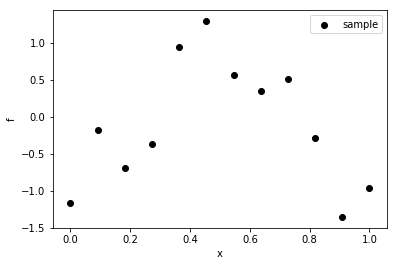

In [75]:
def f(x):
    return -np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

N = 12
sigma = 0.1 #std

X = np.linspace(0, 1, N)[:,None]

Y = f(X) + np.random.normal(0, sigma, (N,1)) #std

plt.scatter(X, Y, label='sample', color='black')
plt.xlabel("x")
plt.ylabel("f")
plt.legend()

In [76]:
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1, name="rbf")
# New test points to sample function from
Xnew = np.linspace(0, 1, 100)[:, None]

# Covariance between training sample points (+ Gaussian noise)
Kxx = k.K(X,X) + 1 * np.eye(N)

# Covariance between training and test points
Kxs = k.K(Xnew, X)

# Covariance between test points
Kss = k.K(Xnew,Xnew)

# The mean of the GP fit (note that @ is matrix multiplcation: A @ B is equivalent to np.matmul(A,B))
mean = Kxs @ np.linalg.inv(Kxx) @ Y
# The covariance matrix of the GP fit
Cov = Kss - Kxs @ np.linalg.inv(Kxx) @ Kxs.T

In [91]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    plt.fill_between(X[:,0], m[:,0] - 1.96*np.sqrt(np.diag(C)), m[:,0] + 1.96*np.sqrt(np.diag(C)), color='lightgrey')
    plt.plot(X, m, color='black', label='GP fit')
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.scatter(X_, Y_, color='black', label='sample')
        plt.legend()

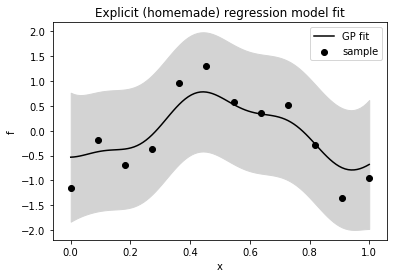

In [93]:
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("Explicit (homemade) regression model fit");

In [42]:
m = GPy.models.GPRegression(X, Y, k)
m 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,1.0,+ve,


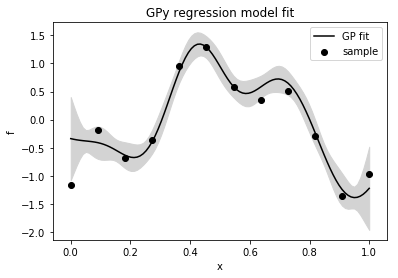

In [94]:
# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("GPy regression model fit");

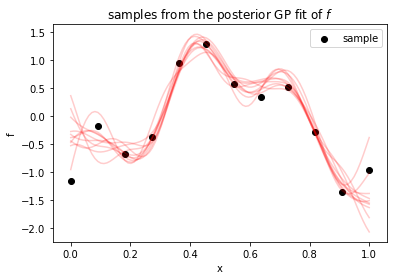

In [102]:
m.Gaussian_noise = 0.01
m.rbf.lengthscale = 0.1


mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

Z = np.random.multivariate_normal(mean[:,0], Cov, 10)

for z in Z:
    plt.plot(Xnew, z, "g-", alpha=0.2, color='red')
plt.scatter(X, Y, color='black', label='sample')
plt.xlabel("x")
plt.ylabel("f")
plt.title("samples from the posterior GP fit of $f$")
plt.legend()